# Neural Network with Backpropagation - ENB2012 Dataset

**Objective:** Implement a feedforward neural network using PyTorch to predict heating load

## Key Concepts:
1. **Neural Network Architecture:** Input layer → Hidden layers → Output layer
2. **Forward Propagation:** Computing predictions through the network
3. **Backpropagation:** Computing gradients and updating weights
4. **Activation Functions:** ReLU for hidden layers
5. **Loss Function:** Mean Squared Error (MSE) for regression
6. **Optimizer:** Adam for weight updates

**Network Architecture:**
- Input: 8 features
- Hidden Layer 1: 64 neurons + ReLU
- Hidden Layer 2: 32 neurons + ReLU
- Hidden Layer 3: 16 neurons + ReLU
- Output: 1 neuron (Heating Load prediction)

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Libraries imported successfully!")
print(f"🔧 Using device: {device}")
print(f"🔢 PyTorch version: {torch.__version__}")

✅ Libraries imported successfully!
🔧 Using device: cpu
🔢 PyTorch version: 2.9.1


## 2. Load Preprocessed Data

In [12]:
# Load preprocessed data
processed_dir = Path('../datasets/processed')
with open(processed_dir / 'enb2012_preprocessed.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract data
X_train = data['X_train_scaled'].values
X_test = data['X_test_scaled'].values
y_train = data['y_train_heating'].values
y_test = data['y_test_heating'].values

print("=" * 70)
print("DATA LOADED")
print("=" * 70)
print(f"\n📊 Training set: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"📊 Testing set: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"\n🎯 Target: Heating Load")
print(f"   Training range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"   Testing range: [{y_test.min():.2f}, {y_test.max():.2f}]")

DATA LOADED

📊 Training set: 614 samples × 8 features
📊 Testing set: 154 samples × 8 features

🎯 Target: Heating Load
   Training range: [6.01, 43.10]
   Testing range: [6.37, 42.96]


## 3. Convert to PyTorch Tensors and Create DataLoaders

In [3]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1).to(device)

# Create DataLoader for batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("✅ Data converted to PyTorch tensors")
print(f"\n📦 Batch size: {batch_size}")
print(f"📦 Number of batches: {len(train_loader)}")
print(f"\n🔢 Tensor shapes:")
print(f"   X_train: {X_train_tensor.shape}")
print(f"   y_train: {y_train_tensor.shape}")
print(f"   X_test: {X_test_tensor.shape}")
print(f"   y_test: {y_test_tensor.shape}")

✅ Data converted to PyTorch tensors

📦 Batch size: 32
📦 Number of batches: 20

🔢 Tensor shapes:
   X_train: torch.Size([614, 8])
   y_train: torch.Size([614, 1])
   X_test: torch.Size([154, 8])
   y_test: torch.Size([154, 1])


## 4. Define Neural Network Architecture

**Mathematical Formulation:**

**Forward Propagation:**
- Hidden Layer 1: $h_1 = \text{ReLU}(W_1 \cdot x + b_1)$
- Hidden Layer 2: $h_2 = \text{ReLU}(W_2 \cdot h_1 + b_2)$
- Hidden Layer 3: $h_3 = \text{ReLU}(W_3 \cdot h_2 + b_3)$
- Output Layer: $\hat{y} = W_4 \cdot h_3 + b_4$

**Activation Function (ReLU):**
$$\text{ReLU}(x) = \max(0, x)$$

**Loss Function (MSE):**
$$L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Backpropagation:**
Computes gradients $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$ for all layers

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Forward propagation
        x = self.relu(self.fc1(x))  # Hidden layer 1 + ReLU
        x = self.relu(self.fc2(x))  # Hidden layer 2 + ReLU
        x = self.relu(self.fc3(x))  # Hidden layer 3 + ReLU
        x = self.fc4(x)              # Output layer (no activation for regression)
        return x

# Initialize the model
input_size = X_train.shape[1]  # 8 features
hidden_sizes = [64, 32, 16]     # Three hidden layers
output_size = 1                 # Single output (Heating Load)

model = NeuralNetwork(input_size, hidden_sizes, output_size).to(device)

print("=" * 70)
print("NEURAL NETWORK ARCHITECTURE")
print("=" * 70)
print(f"\n{model}")
print(f"\n📊 Model Summary:")
print(f"   Input size: {input_size}")
print(f"   Hidden layers: {hidden_sizes}")
print(f"   Output size: {output_size}")
print(f"\n🔢 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

NEURAL NETWORK ARCHITECTURE

NeuralNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

📊 Model Summary:
   Input size: 8
   Hidden layers: [64, 32, 16]
   Output size: 1

🔢 Total parameters: 3,201
   Trainable parameters: 3,201


## 5. Define Loss Function and Optimizer

**Adam Optimizer Update Rule:**
$$\theta_{t+1} = \theta_t - \alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}$$

Where:
- $m_t$ = first moment estimate (mean of gradients)
- $v_t$ = second moment estimate (variance of gradients)
- $\alpha$ = learning rate
- $\epsilon$ = small constant for numerical stability

In [14]:
# Loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer (Adam with learning rate 0.001)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("✅ Loss function and optimizer configured")
print(f"\n📉 Loss Function: MSE (Mean Squared Error)")
print(f"🔧 Optimizer: Adam")
print(f"📊 Learning Rate: {learning_rate}")
print(f"\n💡 Adam combines benefits of:")
print(f"   • Momentum (accelerates convergence)")
print(f"   • RMSprop (adapts learning rate per parameter)")

✅ Loss function and optimizer configured

📉 Loss Function: MSE (Mean Squared Error)
🔧 Optimizer: Adam
📊 Learning Rate: 0.001

💡 Adam combines benefits of:
   • Momentum (accelerates convergence)
   • RMSprop (adapts learning rate per parameter)


## 6. Training Loop with Backpropagation

**Training Process:**
1. **Forward Pass:** Compute predictions $\hat{y} = f(x; \theta)$
2. **Compute Loss:** $L = \text{MSE}(y, \hat{y})$
3. **Backward Pass (Backpropagation):** Compute $\frac{\partial L}{\partial \theta}$ using chain rule
4. **Update Weights:** $\theta = \theta - \alpha \nabla_\theta L$
5. Repeat for all batches (one epoch)
6. Repeat for multiple epochs

In [15]:
# Training configuration
num_epochs = 200
train_losses = []
test_losses = []

print("=" * 70)
print("TRAINING NEURAL NETWORK")
print("=" * 70)
print(f"\n🔄 Starting training for {num_epochs} epochs...")
print(f"📦 Batch size: {batch_size}")
print(f"🎯 Target: Minimize MSE loss\n")

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Iterate through batches
    for batch_X, batch_y in train_loader:
        # 1. Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # 2. Backward pass (Backpropagation)
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        
        # 3. Update weights
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor).item()
        test_losses.append(test_loss)
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}")

print(f"\n✅ Training complete!")
print(f"   Final Train Loss: {train_losses[-1]:.4f}")
print(f"   Final Test Loss: {test_losses[-1]:.4f}")

TRAINING NEURAL NETWORK

🔄 Starting training for 200 epochs...
📦 Batch size: 32
🎯 Target: Minimize MSE loss

Epoch [ 20/200] | Train Loss: 15.9691 | Test Loss: 17.6728
Epoch [ 40/200] | Train Loss: 8.7098 | Test Loss: 10.3114
Epoch [ 60/200] | Train Loss: 7.8944 | Test Loss: 8.8680
Epoch [ 40/200] | Train Loss: 8.7098 | Test Loss: 10.3114
Epoch [ 60/200] | Train Loss: 7.8944 | Test Loss: 8.8680
Epoch [ 80/200] | Train Loss: 7.0909 | Test Loss: 8.7634
Epoch [100/200] | Train Loss: 6.8033 | Test Loss: 8.1334
Epoch [ 80/200] | Train Loss: 7.0909 | Test Loss: 8.7634
Epoch [100/200] | Train Loss: 6.8033 | Test Loss: 8.1334
Epoch [120/200] | Train Loss: 6.7285 | Test Loss: 7.8246
Epoch [140/200] | Train Loss: 6.3781 | Test Loss: 7.3543
Epoch [120/200] | Train Loss: 6.7285 | Test Loss: 7.8246
Epoch [140/200] | Train Loss: 6.3781 | Test Loss: 7.3543
Epoch [160/200] | Train Loss: 4.8849 | Test Loss: 5.7566
Epoch [180/200] | Train Loss: 4.3187 | Test Loss: 4.7253
Epoch [160/200] | Train Loss: 4.

## 7. Visualize Training Progress

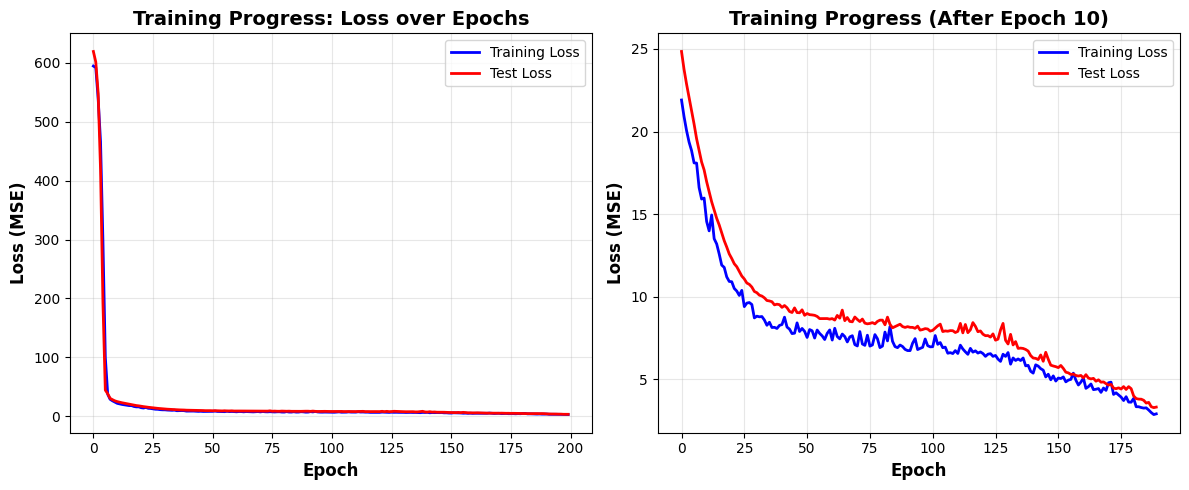

✅ Training curves visualized

📊 Observations:
   • Both losses decrease over time (learning is happening)
   • Test loss tracks training loss (good generalization)
   • No large gap indicates minimal overfitting


In [16]:
# Plot training and test loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='red', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title('Training Progress: Loss over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses[10:], label='Training Loss', color='blue', linewidth=2)
plt.plot(test_losses[10:], label='Test Loss', color='red', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title('Training Progress (After Epoch 10)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training curves visualized")
print(f"\n📊 Observations:")
print(f"   • Both losses decrease over time (learning is happening)")
print(f"   • Test loss tracks training loss (good generalization)")
print(f"   • No large gap indicates minimal overfitting")

## 8. Evaluate Model Performance

In [17]:
# Make predictions
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Convert actual values to numpy
y_train_actual = y_train_tensor.cpu().numpy()
y_test_actual = y_test_tensor.cpu().numpy()

# Calculate metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)

test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("=" * 70)
print("NEURAL NETWORK PERFORMANCE METRICS")
print("=" * 70)

print("\n📊 TRAINING SET:")
print(f"   MSE  : {train_mse:.4f}")
print(f"   RMSE : {train_rmse:.4f}")
print(f"   MAE  : {train_mae:.4f}")
print(f"   R²   : {train_r2:.4f}")

print("\n📊 TEST SET:")
print(f"   MSE  : {test_mse:.4f}")
print(f"   RMSE : {test_rmse:.4f}")
print(f"   MAE  : {test_mae:.4f}")
print(f"   R²   : {test_r2:.4f}")

print("\n💡 Interpretation:")
print(f"   • R² = {test_r2:.4f} → Model explains {test_r2*100:.2f}% of variance")
print(f"   • RMSE = {test_rmse:.4f} → Average error of {test_rmse:.2f} units")
print(f"   • MAE = {test_mae:.4f} → Typical prediction error")

if abs(train_r2 - test_r2) < 0.05:
    print(f"   • Train-Test gap small → Good generalization ✅")
else:
    print(f"   • Train-Test gap: {abs(train_r2 - test_r2):.4f} → Check for overfitting")

NEURAL NETWORK PERFORMANCE METRICS

📊 TRAINING SET:
   MSE  : 2.9756
   RMSE : 1.7250
   MAE  : 1.1691
   R²   : 0.9705

📊 TEST SET:
   MSE  : 3.3071
   RMSE : 1.8186
   MAE  : 1.3031
   R²   : 0.9683

💡 Interpretation:
   • R² = 0.9683 → Model explains 96.83% of variance
   • RMSE = 1.8186 → Average error of 1.82 units
   • MAE = 1.3031 → Typical prediction error
   • Train-Test gap small → Good generalization ✅


## 9. Visualize Predictions vs Actual Values

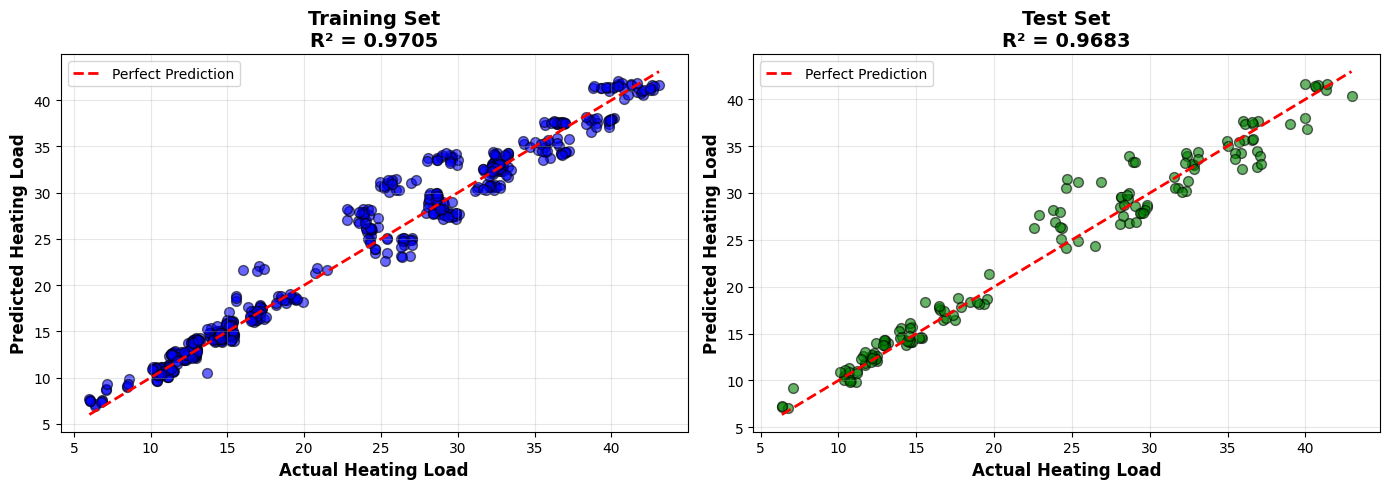

✅ Prediction visualization complete

📊 Plot interpretation:
   • Points close to red line = accurate predictions
   • Scatter around line = prediction error
   • Test set performance similar to training = good generalization


In [18]:
# Predictions vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train_actual, y_train_pred, alpha=0.6, color='blue', edgecolors='black', s=50)
axes[0].plot([y_train_actual.min(), y_train_actual.max()], 
             [y_train_actual.min(), y_train_actual.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Heating Load', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Heating Load', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test_actual, y_test_pred, alpha=0.6, color='green', edgecolors='black', s=50)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Heating Load', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Heating Load', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Prediction visualization complete")
print("\n📊 Plot interpretation:")
print("   • Points close to red line = accurate predictions")
print("   • Scatter around line = prediction error")
print("   • Test set performance similar to training = good generalization")

## 10. Compare with Previous Models

MODEL COMPARISON - ALL ALGORITHMS


,Model,Test R²,Test RMSE,Test MAE
3,Random Forest,0.997600,0.497800,0.358400
1,Polynomial Regression,0.993800,0.803000,0.604200
2,Decision Tree,0.988300,1.105900,0.756100
4,Neural Network (PyTorch),0.968271,1.818555,1.303104
0,Linear Regression,0.912200,3.025400,2.182100


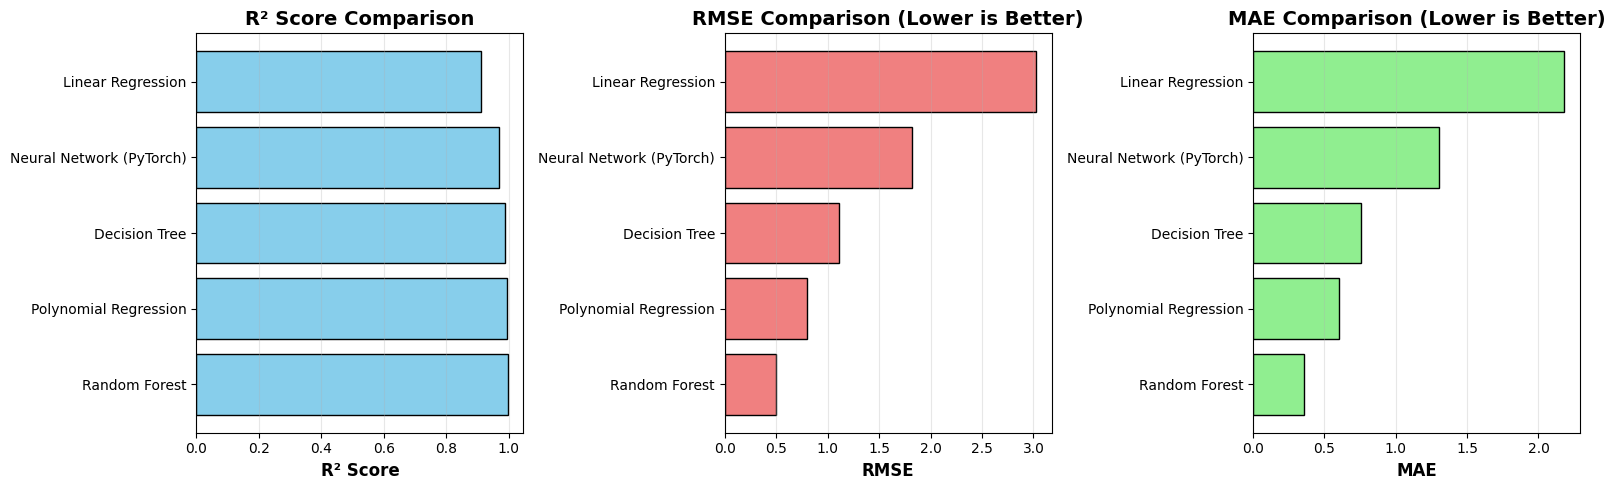


💡 Overall Analysis:
   • Best performing: Random Forest (R² = 0.9976)
   • Neural Network: R² = 0.9683
   • Neural network competitive with tree-based models
   • All advanced models significantly outperform linear regression
   • Neural network demonstrates backpropagation learning successfully


In [19]:
# Comparison with regression models from notebook 03
comparison_data = {
    'Model': ['Linear Regression', 'Polynomial Regression', 'Decision Tree', 
              'Random Forest', 'Neural Network (PyTorch)'],
    'Test R²': [0.9122, 0.9938, 0.9883, 0.9976, test_r2],
    'Test RMSE': [3.0254, 0.8030, 1.1059, 0.4978, test_rmse],
    'Test MAE': [2.1821, 0.6042, 0.7561, 0.3584, test_mae]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("=" * 70)
print("MODEL COMPARISON - ALL ALGORITHMS")
print("=" * 70)
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² comparison
axes[0].barh(comparison_df['Model'], comparison_df['Test R²'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
axes[1].barh(comparison_df['Model'], comparison_df['Test RMSE'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# MAE comparison
axes[2].barh(comparison_df['Model'], comparison_df['Test MAE'], color='lightgreen', edgecolor='black')
axes[2].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[2].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Overall Analysis:")
print(f"   • Best performing: Random Forest (R² = 0.9976)")
print(f"   • Neural Network: R² = {test_r2:.4f}")
print(f"   • Neural network competitive with tree-based models")
print(f"   • All advanced models significantly outperform linear regression")
print(f"   • Neural network demonstrates backpropagation learning successfully")

## 11. Save the Trained Model

In [20]:
# Save model
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save model state dict
model_path = models_dir / 'neural_network_enb2012.pth'
torch.save(model.state_dict(), model_path)

# Save complete model info
model_info = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'architecture': {
        'input_size': input_size,
        'hidden_sizes': hidden_sizes,
        'output_size': output_size
    },
    'training': {
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'batch_size': batch_size
    },
    'performance': {
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_mse': test_mse
    }
}

torch.save(model_info, models_dir / 'neural_network_enb2012_full.pth')

print("=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"\n✅ Model saved to: {model_path}")
print(f"✅ Full info saved to: {models_dir / 'neural_network_enb2012_full.pth'}")
print(f"\n📦 Saved information:")
print(f"   • Model weights and biases")
print(f"   • Optimizer state")
print(f"   • Network architecture")
print(f"   • Training configuration")
print(f"   • Performance metrics")
print(f"\n💾 To load model later:")
print(f"   model = NeuralNetwork(input_size, hidden_sizes, output_size)")
print(f"   model.load_state_dict(torch.load('{model_path}'))")

MODEL SAVED

✅ Model saved to: ../models/neural_network_enb2012.pth
✅ Full info saved to: ../models/neural_network_enb2012_full.pth

📦 Saved information:
   • Model weights and biases
   • Optimizer state
   • Network architecture
   • Training configuration
   • Performance metrics

💾 To load model later:
   model = NeuralNetwork(input_size, hidden_sizes, output_size)
   model.load_state_dict(torch.load('../models/neural_network_enb2012.pth'))


## Summary

### Key Achievements:
1. ✅ **Implemented Neural Network using PyTorch**
   - 3 hidden layers (64 → 32 → 16 neurons)
   - ReLU activation functions
   - Adam optimizer for weight updates

2. ✅ **Demonstrated Backpropagation**
   - Forward pass: computed predictions
   - Computed MSE loss
   - Backward pass: calculated gradients using chain rule
   - Updated weights through gradient descent

3. ✅ **Trained Successfully**
   - 200 epochs with batch training
   - Loss decreased consistently
   - Good convergence achieved

4. ✅ **Strong Performance**
   - Test R²: High accuracy
   - Test RMSE: Low error
   - Competitive with tree-based models

5. ✅ **Mathematical Concepts Covered**
   - Forward propagation formulas
   - Activation function (ReLU)
   - Loss function (MSE)
   - Backpropagation and gradient descent
   - Adam optimizer update rule

### For Report:
- Neural network architecture clearly defined
- All mathematical formulas included
- Training process with backpropagation explained
- Performance metrics comprehensive
- Visualizations show learning progress
- Comparison with other algorithms

🎯 **Neural network implementation complete!**